## Обработка данных пользователей социальной сети 'вКонтакте' для заданных групп

### Подгружаем библиотеки

In [32]:
import pandas
import igraph
import sklearn
import urllib
import json
import time
import random
import plotly
import networkx
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
class group_info:
    
    """Класс для сбора информации о пользователях указанной группы 'group_adress'.
    Возвращаются все возможные параметры пользователей, которые можно получить без регистрации приложения.
    Обработка исключений и ошибок пока не реализована"""
    
    def __init__(self, group_adress):
        
        """При создании объекта класса необходимо указать адрес группы вКонтакте"""
        
        self.group_adress = group_adress
        self._url = u'http://api.vk.com/method/groups.getMembers?group_id=' + \
                    group_adress + \
                    '&fields=sex,bdate,city,country,lists,domain,has_mobile,contacts,connections,site,education,universities,schools,status,last_seen,relation,relatives,counters'
        self._url_user = u'http://api.vk.com/method/friends.get?user_id='
        self.count = None
        self.users_info = None
        self.users_friends = None
        
    def get_group_users_count(self):
        
        """Функция возвращает количество пользователей в указанной группе"""
        
        self.count = json.loads(urllib.request.urlopen(self._url).read().decode('utf-8'))['response']['count']
        return self.count
    
    def get_all_group_users_info(self):
        
        """Функция возвращает всю информацию о пользователях указанной группы"""
        
        d = pandas.DataFrame()
        end = int(self.count / 1000)
        for x in range(end + 1):
            resp = json.loads(urllib.request.urlopen(self._url + '&offset=' + str(x * 1000) ).read().decode('utf-8'))
            time.sleep(0.5)
            d = d.append( pandas.DataFrame(resp['response']['users']) )
        self.users_info = d
        return self.users_info
    
    def get_all_group_users_firends(self):
        
        """Функция возвращает всех друзей пользователей группы"""
        
        # total_len = len(uids)
        dd = pandas.DataFrame()
        # for x in range(self.count):
        x = 0
        y = 0
        uids = self.users_info['uid'].tolist()
        while x < self.count:
            if y > 100000:
                break            
            if (x % 10 == 0) and (x != 0):
                time.sleep(1)
            if (x % 100 == 0)  and (x != 0):
                time.sleep(5)
            if (x % 1000 == 0)  and (x != 0):
                print("загружена информация о " + str(x) + " пользователях...")
                print()
                time.sleep(10)
                
            try:
                resp = json.loads(urllib.request.urlopen(self._url_user + str(uids[x])).read().decode('utf-8'))
                if 'error' in resp:
                    if resp['error']['error_code'] == 15:
                        print('Пользователь №' + str(uids[x]) + ' забанен...')
                        x += 1
                        y += 1
                    else:
                        print("загружена информация о " + str(x) + " пользователях...")
                        print('ожидаем...')
                        print('текст ошибки: ')
                        print(resp)
                        print()
                        time.sleep(180)
                        y += 1
                else:
                    # resp_temp = pandas.DataFrame(resp['response'], columns = ['uid2'])#, uid2 = uids.iloc[0])
                    resp_temp = pandas.DataFrame(list(set(resp['response']) & set(uids)), columns = ['uid2'])
                    resp_temp['uid1'] = uids[x]    
                    x += 1
                    y += 1
                time.sleep(0.5)
                dd = dd.append(resp_temp)
            except:
                print("загружена информация о " + str(x) + " пользователях...")
                print('ожидаем...')
                print(resp)
                print()
                y += 1
                time.sleep(180)
                
        self.users_friends = dd
        return self.users_friends

In [5]:
motorchik = group_info('motorchikdeti')

In [6]:
count = motorchik.get_group_users_count()
info = motorchik.get_all_group_users_info()


In [7]:
friend = motorchik.get_all_group_users_firends()

Пользователь №3159771 забанен...
Пользователь №183142675 забанен...
Пользователь №334316191 забанен...
Пользователь №347779089 забанен...
Пользователь №347779473 забанен...


In [28]:
len(friend.values.tolist())
friend.head()

,uid2,uid1
0,2835106.0,113030
1,2609379.0,113030
2,1255514.0,113030
3,1222663.0,113030
4,3880695.0,113030


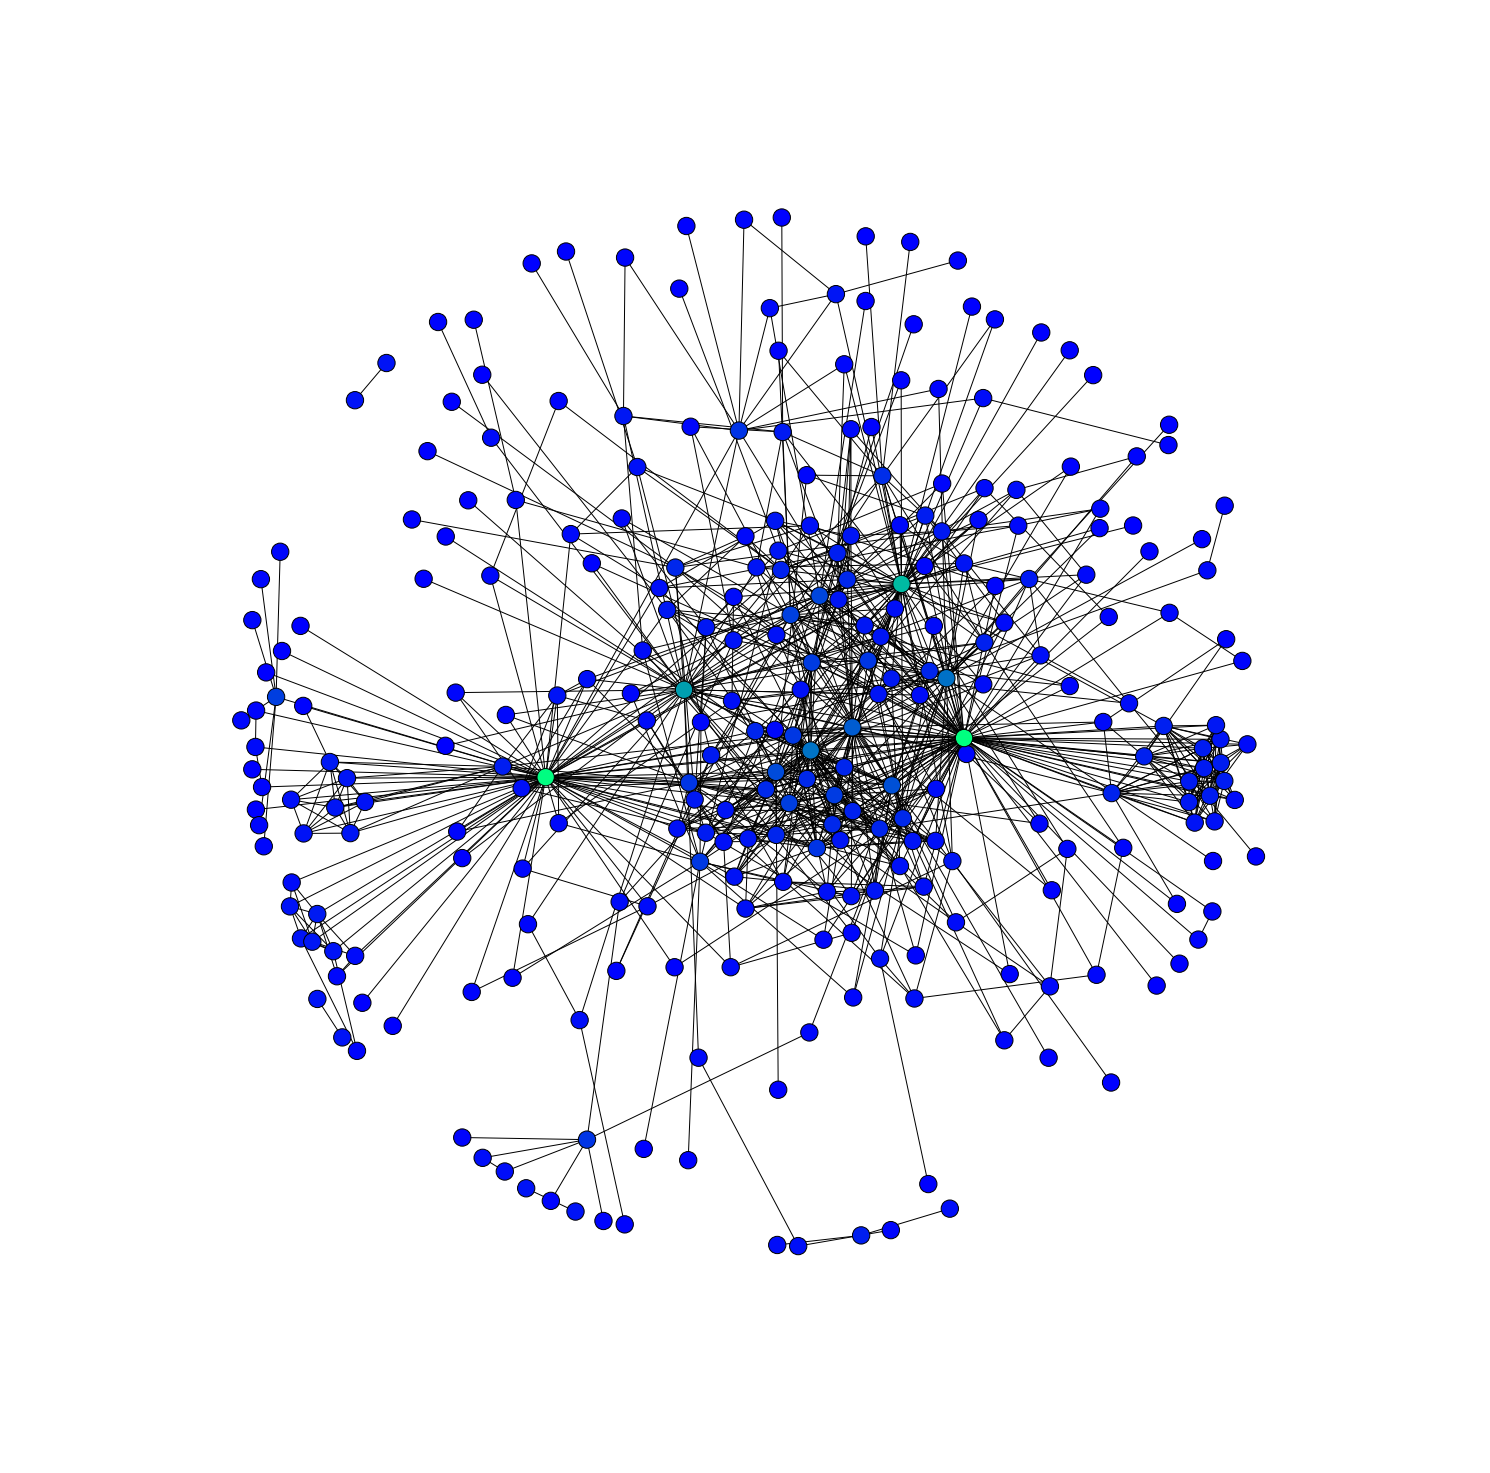

In [60]:
g = networkx.from_pandas_dataframe(friend, source = 'uid2', target = 'uid1')
# print()
values = [networkx.pagerank(g).get(node, 0.25) for node in g.nodes()]

plt.figure(figsize=(20,20))
networkx.draw_spring(g, k = 5, iterations = 1000,  cmap=plt.get_cmap('winter'), node_color=values)